## 모듈화
https://github.com/mesutdmn/Autonomous-Multi-Agent-Systems-with-CrewAI-Essay-Writer

In [ ]:
# from google.colab import drive

# # Google Drive 마운트
# drive.mount('/content/drive')

# # Base Folder 및 PDF 경로 설정
# base_folder = "/content/drive/MyDrive/AiffelThon/csy/Langgraph_tutorial"
# pdf_folder = "/content/drive/MyDrive/AiffelThon/Input_data"

In [ ]:
# !pip install langgraph langchain langchain_openai pypdf2 sentence-transformers faiss-gpu faiss-cpu langchain-community langchain_teddynote python-dotenv

In [ ]:
# !pip install pypdf

In [7]:
import os
import getpass
from dotenv import load_dotenv

## retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores.base import VectorStoreRetriever

## tool
from langgraph.prebuilt import ToolExecutor
from langchain.tools.retriever import create_retriever_tool

## agent
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

## Nodes and Edges
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser


## Graph
from langgraph.graph import END, StateGraph

## Response
import pprint
from langchain_core.messages import HumanMessage

c:\Users\ghckd\anaconda3\envs\voltai\Lib\site-packages\IPython\core\interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# def _set_if_undefined(var: str):
#     # 주어진 환경 변수가 설정되어 있지 않다면 사용자에게 입력을 요청하여 설정합니다.
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")


# # OPENAI_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
# _set_if_undefined("OPENAI_API_KEY")
# # LANGCHAIN_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
# _set_if_undefined("LANGCHAIN_API_KEY")

# # LangSmith 추적 기능을 활성화합니다. (선택적)
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

### PDF 파일을 경로로 불러들임

In [ ]:
# input_pdfs = []  # PDF 경로를 저장할 리스트

# for i in range(1, 144):
#     input_pdf = os.path.join(pdf_folder, f"paper_{str(i).zfill(3)}.pdf")
#     input_pdfs.append(input_pdf)

# # 출력 (테스트용)
# for pdf in input_pdfs:
#     print(pdf)

In [7]:
def embedding_file(file: str) -> VectorStoreRetriever:
    """문서를 청크 단위로 분할하고 임베딩 모델(text-embedding-ada-002)을 통해 임베딩하여 vector store에 저장합니다. 이후 vector store를 기반으로 검색하는 객체를 생성합니다.

    Args:
        file (str): pdf 문서 경로

    Returns:
        VectorStoreRetriever: 검색기
    """

    ## 긴 텍스트를 작은 청크로 나누는 데 사용되는 클래스
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500,         ## 최대 청크 길이 정의
        chunk_overlap=100,      ## 청크 간 겹침 길이 정의
        separators=["\n\n"]     ## 텍스트를 나눌 때 사용할 구분자를 지정 (문단)
    )

    ## PDF 파일 불러오기
    loader = PyPDFLoader(f"{file}")
    docs = loader.load_and_split(text_splitter=splitter)

    ## Embedding 생성 및 vector store에 저장
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(
        documents=docs,         ## 벡터 저장소에 추가할 문서 리스트
        embedding=embeddings    ## 사용할 임베딩 함수
    )

    ## 검색기로 변환: 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공
    retriever = vector_store.as_retriever(
        search_type="similarity"    ## 어떻게 검색할 것인지? default가 유사도
    )

    return retriever

## 아래의 input_pdfs[i]를 조절해서 input을 대량으로 끌고오는 걸 고려해봐야함

In [8]:
retriever = embedding_file(file="../paper_139.pdf")

In [9]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [17]:
from langchain_teddynote.messages import messages_to_history
from langchain_core.documents.base import Document
from langchain_teddynote.evaluator import GroundednessChecker

def format_docs(docs: list[Document]) -> str:
    """문시 리스트에서 텍스트를 추출하여 하나의 문자로 합치는 기능을 합니다.

    Args:
        docs (list[Document]): 여러 개의 Documnet 객체로 이루어진 리스트

    Returns:
        str: 모든 문서의 텍스트가 하나로 합쳐진 문자열을 반환
    """
    return "\n\n".join(doc.page_content for doc in docs)

# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # prompt 설정
    prompt = PromptTemplate(
        template="""
        Based on the following document, please provide an answer to the given question.

        Document:
        {context}

        Question:
        {question}

        Answer:
        """,
        input_variables=["context", "question"],
        )

    # llm 호출
    llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0.7,
        streaming=True
        )

    # 체인 호출
    chain = prompt | llm | JsonOutputParser()

    response = chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response,
        messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    retrieval_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o", temperature=0.7), target="retrieval-answer"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = retrieval_answer_relevant.invoke(
        {"context": state["context"], "answer": state["answer"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]

In [18]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # _start_ -> 검색 시작
workflow.add_edge("llm_answer", "relevance_check")  # 답변 생성 -> 관련성 체크

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "yes": END,  # 관련성이 있으면 _end_로 이동합니다.
        "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.
    },
)


# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

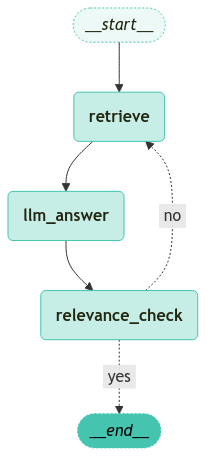

In [19]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [59]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 4개의 질문 입력
questions = [
    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {
            "CAM (Cathode Active Material)": {
                "Stoichiometry information": "NCM-622",
                "Commercial NCM": "No",
                "Lithium source": "LiOH",
                "Synthesis method": "co-precipitation",
                "Crystallization method": "Hydrothermal",
                "Crystallization temperature": "100°C",
                "Crystallization time": "12 hr",
                "Doping": "Zr4+ doping",
                "Coating": "ZrO2 coating",
                "Additional treatment": "None"
                }
        }
    ]
    """,    
    
    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {
            "Electrode (only for coin-cell (half-cell))": {
                "Active material : Conductive additive : Binder ratio": "90 : 5 : 5",
                "Electrolyte": "LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)",
                "Additive": "FEC 10% addition",
                "Electrode thickness": "100 µm",
                "Only Cathode Electrode diameter": "14π",
                "Loading density (mass loading of NCM)": "0.005 g/cm^2",
                "Additional treatment for electrode": "None"
                },
        }
    ]
    """,

    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {        
            "Morphological results": {
                "Explanation of SEM results": "Fig. 2a, b; the NCM-622 seems to have more or less a spherical morphology with a diameter of 3–5 µm, composed of densely packed primary particles",
                "Explanation of TEM results": "None"
                },    
        }
    ]
    """,

    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {            
            "Cathode Performance": {
                "Capacity at all C-rate, mAh/g (with electrode state)": [{
                "214.5 mAh/g": "@0.1C, ZrO2-coated",
                "200.8 mAh/g": "@0.5C, ZrO2-coated"
                }],
                "Voltage range": "2.8–4.3 V",
                "Temperature": "Room temperature and 55°C"
                }
        }
    ]
    """
]


# 4개의 질문에 대해 그래프 실행 및 출력
outputs = []
for i, question in enumerate(questions):
    inputs = GraphState(question=question)
    invoke_graph(
        graph=app,
        inputs=inputs,
        config=config,
        node_names=["relevance_check", "llm_answer"]
    )
    output = app.get_state(config).values
    outputs.append(output)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{'CAM (Cathode Active Material)': {'Stoichiometry information': 'Li[Ni0.73Co0.12Mn0.15]O2', 'Commercial NCM': 'No', 'Lithium source': 'LiOH·H2O', 'Synthesis method': 'co-precipitation', 'Crystallization method': 'Heating', 'Crystallization temperature': '750°C', 'Crystallization time': '20 hr', 'Doping': 'None', 'Coating': 'Al2O3 coating', 'Additional treatment': 'Freeze drying or heat drying'}}
('user', 'Below are instructions for filling out items by referring to the examples.\n    The values shown to the right of the colon (“:”) are examples;\n    please delete them after reviewing and rewrite them with the values found in the PDF.\n    If any item is not mentioned in the PDF, do not remove it—write “None.”\n    [\n        {\n            "CAM (Cathode Active Material)": {\n                "Stoichiometry information": "NCM-622",\n                "Commercial NCM": "No",\n                "Lithium source": "LiOH",\

In [60]:
import pandas as pd
outputs_dict = outputs[0]["answer"][0]["CAM (Cathode Active Material)"] | outputs[1]["answer"][0]["Electrode (only for coin-cell (half-cell))"] | outputs[2]["answer"][0]["Morphological results"] | outputs[3]["answer"][0]["Cathode Performance"]

pd.DataFrame(outputs_dict)


,Stoichiometry information,Commercial NCM,Lithium source,Synthesis method,Crystallization method,Crystallization temperature,Crystallization time,Doping,Coating,Additional treatment,...,Additive,Electrode thickness,Only Cathode Electrode diameter,Loading density (mass loading of NCM),Additional treatment for electrode,Explanation of SEM results,Explanation of TEM results,"Capacity at all C-rate, mAh/g (with electrode state)",Voltage range,Temperature
0,Li[Ni0.73Co0.12Mn0.15]O2,No,LiOH·H2O,co-precipitation,Heating,750°C,20 hr,None,Al2O3 coating,Freeze drying or heat drying,...,None,None,1.5 cm^2,0.0025 g/cm^2,None,"Fig. 2a, b, c; the pristine Li[Ni0.73Co0.12Mn0...","Fig. 3a, b, c; the pristine material shows a s...","{'214 mAh/g': '@0.1C, FD-Al2O3-coated', '192 m...",3.0–4.3 V,Room temperature (25°C) and elevated temperatu...


In [61]:
outputs_dict

{'Stoichiometry information': 'Li[Ni0.73Co0.12Mn0.15]O2',
 'Commercial NCM': 'No',
 'Lithium source': 'LiOH·H2O',
 'Synthesis method': 'co-precipitation',
 'Crystallization method': 'Heating',
 'Crystallization temperature': '750°C',
 'Crystallization time': '20 hr',
 'Doping': 'None',
 'Coating': 'Al2O3 coating',
 'Additional treatment': 'Freeze drying or heat drying',
 'Active material : Conductive additive : Binder ratio': '80 : 10 : 10',
 'Electrolyte': 'LiPF6 (EC, DEC, DMC mixture in a 1:1:1 volume ratio)',
 'Additive': 'None',
 'Electrode thickness': 'None',
 'Only Cathode Electrode diameter': '1.5 cm^2',
 'Loading density (mass loading of NCM)': '0.0025 g/cm^2',
 'Additional treatment for electrode': 'None',
 'Explanation of SEM results': 'Fig. 2a, b, c; the pristine Li[Ni0.73Co0.12Mn0.15]O2 material has well-dispersed spherical shape with an average particle size of approximately 12 µm, composed of primary grains of 100-200 nm. The morphology of the FD-Al2O3-coated and HD-Al2O3

In [54]:
outputs[3]["answer"][0]["Cathode Performance"]

{'Capacity at all C-rate, mAh/g (with electrode state)': {'214 mAh/g': '@0.1C, FD-Al2O3-coated',
  '226 mAh/g': '@0.1C, pristine',
  '192 mAh/g': '@0.1C, HD-Al2O3-coated'},
 'Voltage range': '3.0–4.3 V',
 'Temperature': 'Room temperature (25°C) and elevated temperature (55°C)'}

In [2]:
import yaml

questions = [
    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {
            "CAM (Cathode Active Material)": {
                "Stoichiometry information": "NCM-622",
                "Commercial NCM": "No",
                "Lithium source": "LiOH",
                "Synthesis method": "co-precipitation",
                "Crystallization method": "Hydrothermal",
                "Crystallization temperature": "100°C",
                "Crystallization time": "12 hr",
                "Doping": "Zr4+ doping",
                "Coating": "ZrO2 coating",
                "Additional treatment": "None"
                }
        }
    ]
    """,    
    
    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {
            "Electrode (only for coin-cell (half-cell))": {
                "Active material : Conductive additive : Binder ratio": "90 : 5 : 5",
                "Electrolyte": "LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)",
                "Additive": "FEC 10% addition",
                "Electrode thickness": "100 µm",
                "Only Cathode Electrode diameter": "14π",
                "Loading density (mass loading of NCM)": "0.005 g/cm^2",
                "Additional treatment for electrode": "None"
                },
        }
    ]
    """,

    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {        
            "Morphological results": {
                "Explanation of SEM results": "Fig. 2a, b; the NCM-622 seems to have more or less a spherical morphology with a diameter of 3–5 µm, composed of densely packed primary particles",
                "Explanation of TEM results": "None"
                },    
        }
    ]
    """,

    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”
    [
        {            
            "Cathode Performance": {
                "Capacity at all C-rate, mAh/g (with electrode state)": [{
                "214.5 mAh/g": "@0.1C, ZrO2-coated",
                "200.8 mAh/g": "@0.5C, ZrO2-coated"
                }],
                "Voltage range": "2.8–4.3 V",
                "Temperature": "Room temperature and 55°C"
                }
        }
    ]
    """
]

data = {"questions": questions}

with open("questions.yaml", "w", encoding="utf-8") as file:
    yaml.dump(data, file, allow_unicode=True, default_flow_style=False)


In [ ]:
# YAML 파일 불러오기
def load_yaml(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data

# 예제: questions.yaml 파일 불러오기
file_path = "questions.yaml"
yaml_data = load_yaml(file_path)

# 불러온 데이터 출력
print(yaml_data)